2025-11-08 09:38:30.085 | INFO     | __main__:<module>:37 - Loaded WhatsApp dataset: 4565 messages
2025-11-08 09:38:30.163 | INFO     | __main__:<module>:58 - 824 messages contain a question mark
2025-11-08 09:38:30.170 | INFO     | __main__:<module>:66 - Aggregated text per author: 56 authors
2025-11-08 09:38:30.257 | INFO     | __main__:<module>:71 - Trigram feature matrix shape: (56, 6471)
/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_68000/200441307.py:97: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


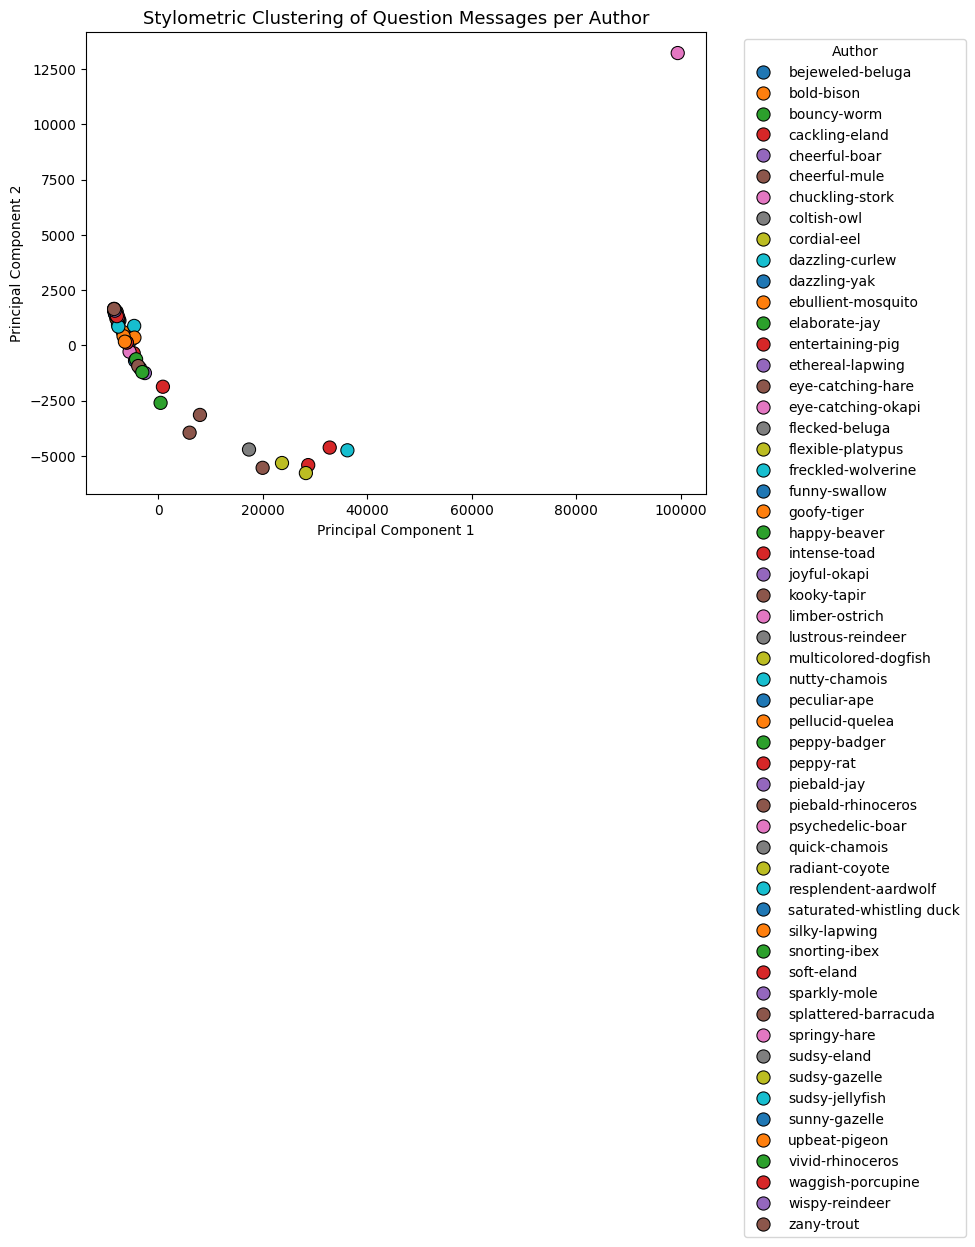

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_68000/200441307.py:102: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance, method="ward")


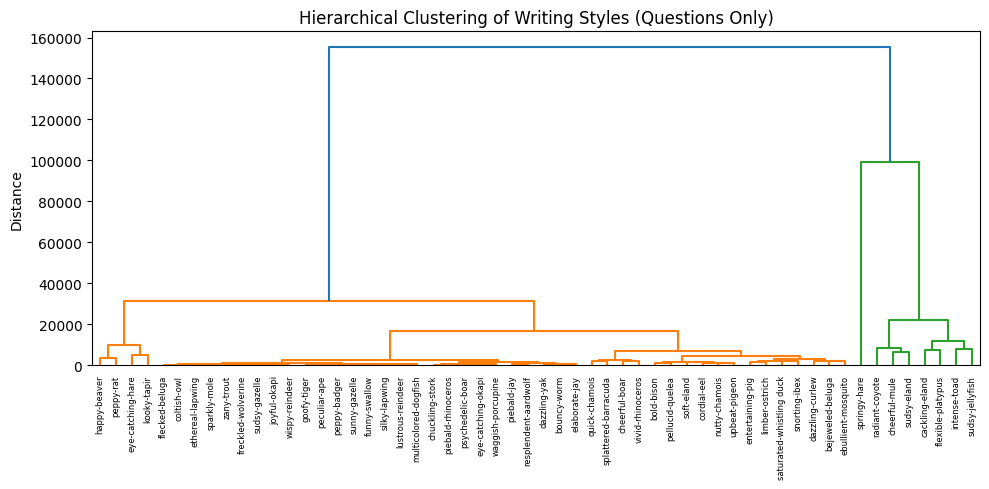

=== Authors in this cluster ===
               author             x            y
3      cackling-eland  28716.538513 -5419.230559
5       cheerful-mule  19995.750682 -5543.332942
18  flexible-platypus  28272.833321 -5780.106343
23       intense-toad  32831.481921 -4626.182306
38     radiant-coyote  23699.286429 -5325.884208
47        sudsy-eland  17388.656075 -4714.908170
49    sudsy-jellyfish  36217.862118 -4750.425981

Sample messages from authors in this region (n=10):

--- cackling-eland ---
• leuk! en gefeliciteerd. 🌷🌸🪻
• beste buren, goedenmorgen. er wordt bij 241 gewerkt vandaag en t/m zaterdag 5 april. lekage onderzoek door sop (bij badkamer/hal) en verbouwing. excuus voor het ongemaak! lift wordt beschermt en alles schoon gemaakt. er staat ook een container beneden een paar dagen. groet.
• beste buren, zoals eerder aangegeven is bij 241 verbouwing aan de gang. deze week wordt de vloer in een deel van de woning (slaapkamers) vervangen. volgende week even de badkamer afronden. d

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_68000/200441307.py:164: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


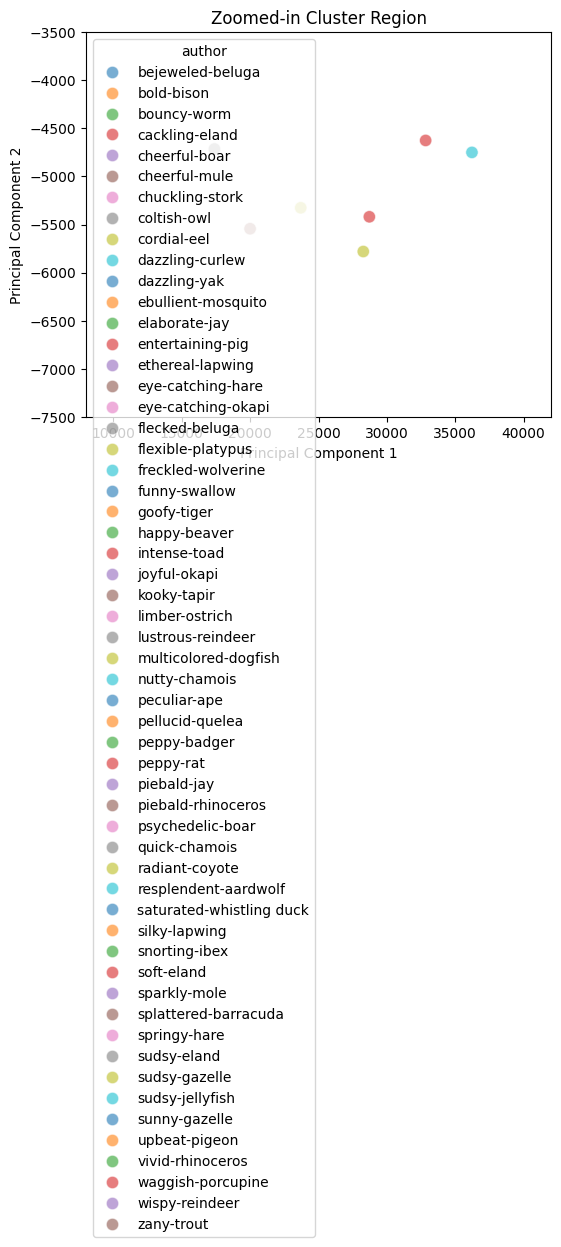


Cluster summary saved to cluster_summary.csv


In [2]:
# %%
"""
Stylometric Analysis of WhatsApp Messages (Questions Only)
----------------------------------------------------------
This script analyzes writing patterns of residents in an apartment group
using character trigram stylometry. It also allows you to inspect specific
clusters (regions) in the PCA visualization to see which authors are grouped
together and what kind of messages they write.
"""

# %% Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from loguru import logger
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# %% Load dataset
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run src/preprocess.py first!")

wa_df_all = pd.read_parquet(datafile)
logger.info(f"Loaded WhatsApp dataset: {wa_df_all.shape[0]} messages")

# %% Clean text
def clean_message(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove links
    text = text.replace("\n", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

wa_df_all["clean_text"] = wa_df_all["message"].apply(clean_message)
wa_df_all = wa_df_all[wa_df_all["clean_text"].str.len() > 0]

# %% Identify question messages
# wa_df_all["is_question"] = wa_df_all["clean_text"].str.contains(r"\?")

# exclamation mark presence (for later analysis)
wa_df_all["is_question"] = wa_df_all["clean_text"].str.contains(r"\!")

# %% Filter only question messages
wa_q = wa_df_all[wa_df_all["is_question"]].copy()
logger.info(f"{wa_q.shape[0]} messages contain a question mark")

# %% Group messages per author and concatenate text
author_texts = (
    wa_q.groupby("author")["clean_text"]
    .apply(lambda x: " ".join(x))
    .reset_index()
)
logger.info(f"Aggregated text per author: {author_texts.shape[0]} authors")

# %% Create trigram-based stylometric vectors
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(author_texts["clean_text"])
logger.info(f"Trigram feature matrix shape: {X.shape}")

# %% Compute pairwise Manhattan distances
distance = manhattan_distances(X, X)

# %% PCA for visualization
pca = PCA(n_components=2)
coords = pca.fit_transform(distance)
author_texts["x"] = coords[:, 0]
author_texts["y"] = coords[:, 1]

# %% Scatterplot: writing-style clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=author_texts,
    x="x",
    y="y",
    hue="author",
    palette="tab10",
    s=90,
    edgecolor="black",
)
plt.title("Stylometric Clustering of Question Messages per Author", fontsize=13)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# %% Hierarchical clustering dendrogram
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(distance, method="ward")
dendrogram(linkage_matrix, labels=author_texts["author"].values)
plt.title("Hierarchical Clustering of Writing Styles (Questions Only)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# %% Function to inspect clusters
def inspect_cluster(df_authors, df_messages, xmin, xmax, ymin, ymax, sample_n=10):
    """
    Selects authors and messages from a PCA region.

    Parameters:
    - df_authors: DataFrame with ['author', 'x', 'y']
    - df_messages: Original question-level DataFrame (wa_q)
    - xmin, xmax, ymin, ymax: coordinate range of cluster
    - sample_n: number of random messages to preview per author

    Returns:
    - cluster_authors_df: authors within coordinate range
    """
    cluster_authors_df = df_authors[
        (df_authors["x"] > xmin) & (df_authors["x"] < xmax)
        & (df_authors["y"] > ymin) & (df_authors["y"] < ymax)
    ].copy()

    if cluster_authors_df.empty:
        logger.warning("No authors found in this coordinate range.")
        return None

    print("=== Authors in this cluster ===")
    print(cluster_authors_df[["author", "x", "y"]])
    print("================================")

    selected_authors = cluster_authors_df["author"].tolist()
    subset = df_messages[df_messages["author"].isin(selected_authors)]

    print(f"\nSample messages from authors in this region (n={sample_n}):")
    for auth in selected_authors:
        print(f"\n--- {auth} ---")
        sample_msgs = subset[subset["author"] == auth]["clean_text"].sample(
            min(sample_n, len(subset[subset["author"] == auth])), random_state=42
        )
        for msg in sample_msgs:
            print(f"• {msg}")

    # Optional zoomed-in scatterplot
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df_authors,
        x="x",
        y="y",
        hue="author",
        alpha=0.6,
        palette="tab10",
        s=80,
    )
    plt.xlim(xmin - 2000, xmax + 2000)
    plt.ylim(ymin - 1000, ymax + 1000)
    plt.title("Zoomed-in Cluster Region")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.tight_layout()
    plt.show()

    return cluster_authors_df

# %% Example: Inspect the encircled cluster (adjust as needed)
# Based on your image: roughly x = 5k–15k, y = –4500 to –3000
# cluster_df = inspect_cluster(author_texts, wa_q, xmin=5000, xmax=15000, ymin=-4500, ymax=-3000)
cluster_df = inspect_cluster(author_texts, wa_q, xmin=10000, xmax=40000, ymin=-6500, ymax=-4500)

# %% Save summary statistics for the cluster
if cluster_df is not None and not cluster_df.empty:
    selected_authors = cluster_df["author"].tolist()
    cluster_summary = (
        wa_q[wa_q["author"].isin(selected_authors)]
        .groupby("author")
        .agg(
            total_questions=("is_question", "sum"),
            avg_length=("message_length", "mean"),
            emoji_ratio=("has_emoji", "mean"),
        )
        .reset_index()
    )
    cluster_summary.to_csv("cluster_summary.csv", index=False)
    print("\nCluster summary saved to cluster_summary.csv")


2025-11-08 17:05:53.557 | INFO     | __main__:<module>:37 - Loaded WhatsApp dataset: 4565 messages
2025-11-08 17:05:53.615 | INFO     | __main__:<module>:56 - 1310 messages contain a question mark or exclamation mark
2025-11-08 17:05:53.621 | INFO     | __main__:<module>:64 - Aggregated text per author: 66 authors
2025-11-08 17:05:53.710 | INFO     | __main__:<module>:69 - Trigram feature matrix shape: (66, 7707)
/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_76781/2666884522.py:95: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


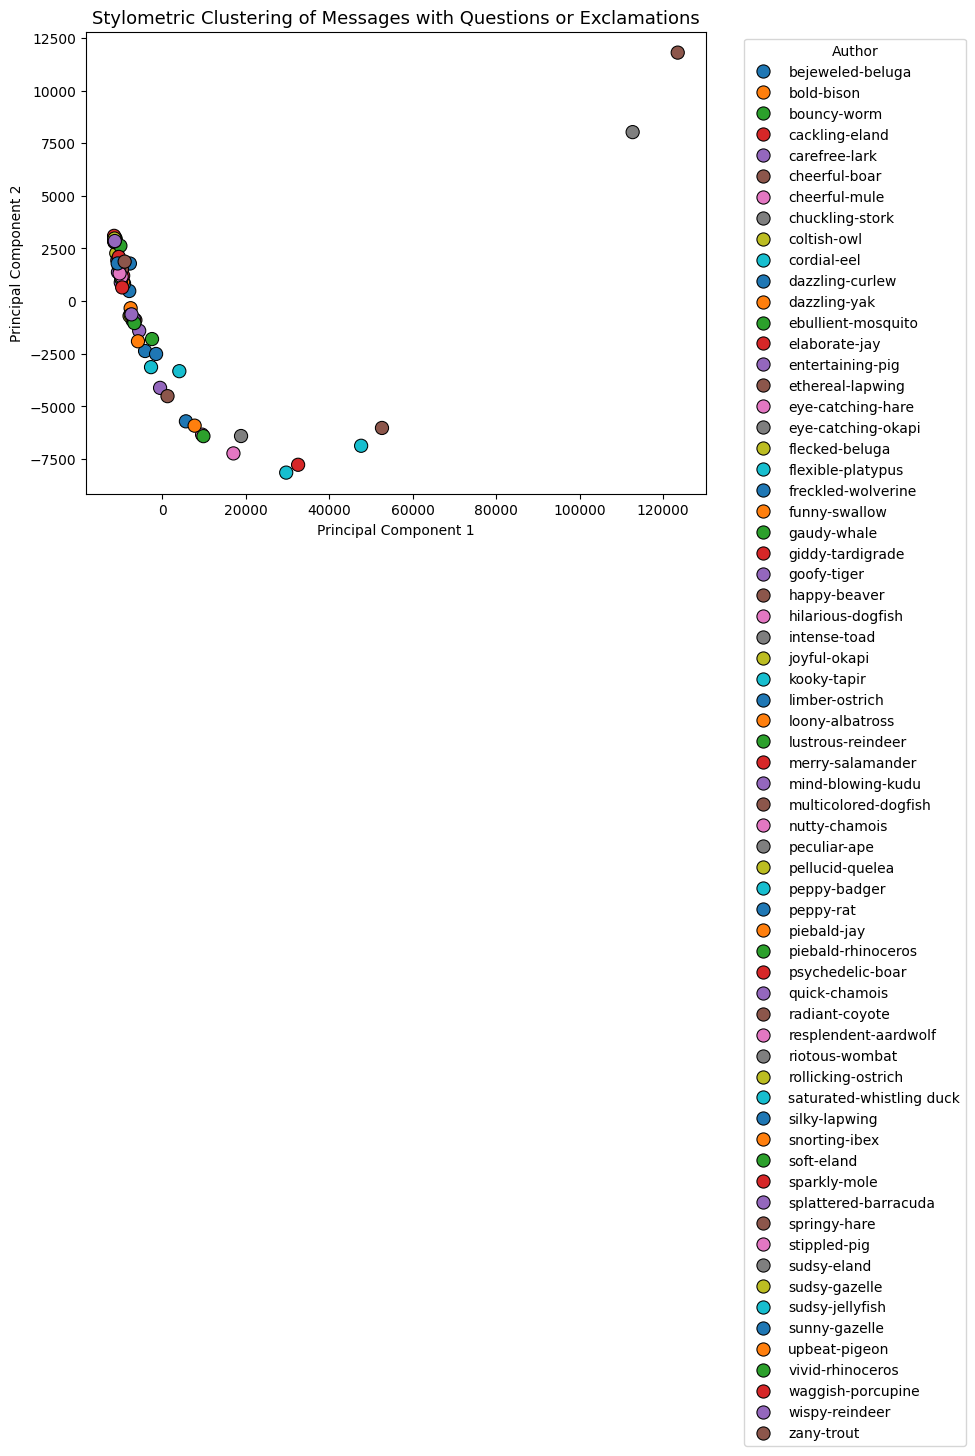

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_76781/2666884522.py:100: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance, method="ward")


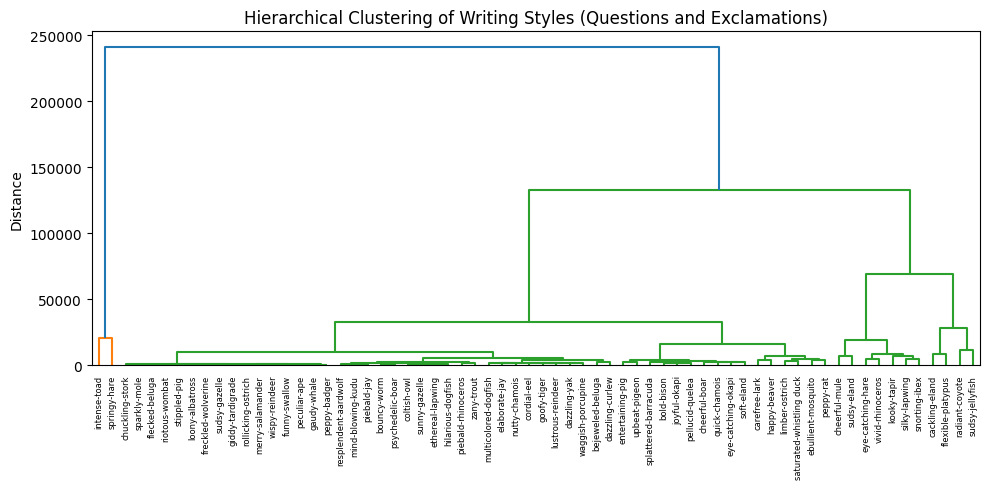

=== Authors in this cluster ===
               author             x            y
6       cheerful-mule  17010.587347 -7232.956438
16  eye-catching-hare   9499.774820 -6342.708940
50      silky-lapwing   5618.872482 -5710.335244
51      snorting-ibex   7709.162245 -5915.204854
57        sudsy-eland  18834.147383 -6407.561330
62   vivid-rhinoceros   9815.161946 -6413.331831

Sample messages from authors in this region (n=10):

--- cheerful-mule ---
• graag gedaan allemaal! over enkele weken kunnen wij weer volop genieten van ons bloeiende tuintje!💐
• henk dankjewel!
• richard heeft een duidelijke uitleg gegeven, alle vragen beantwoord!
• ineke dank voor de info ! genoteerd !
• dankje, mooie frisse kleur!
• dankje tim! 232 graag één sleutel!
• jaaaaaaa, lijkt mijn ook,hebben het er vaker over gehad, hoor er niets meer over, zou mooi zijn 2 vliegen in één klap!
• eindelijk is het bekend wie er zo een troep van maakt!!! ‎[18/06/2024, 08:45:34] ~ maaike françoys: ‎image omitted ‎[18/06/2024,

/var/folders/hv/m4f2vdm11q911kmp31zcg4t40000gn/T/ipykernel_76781/2666884522.py:162: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


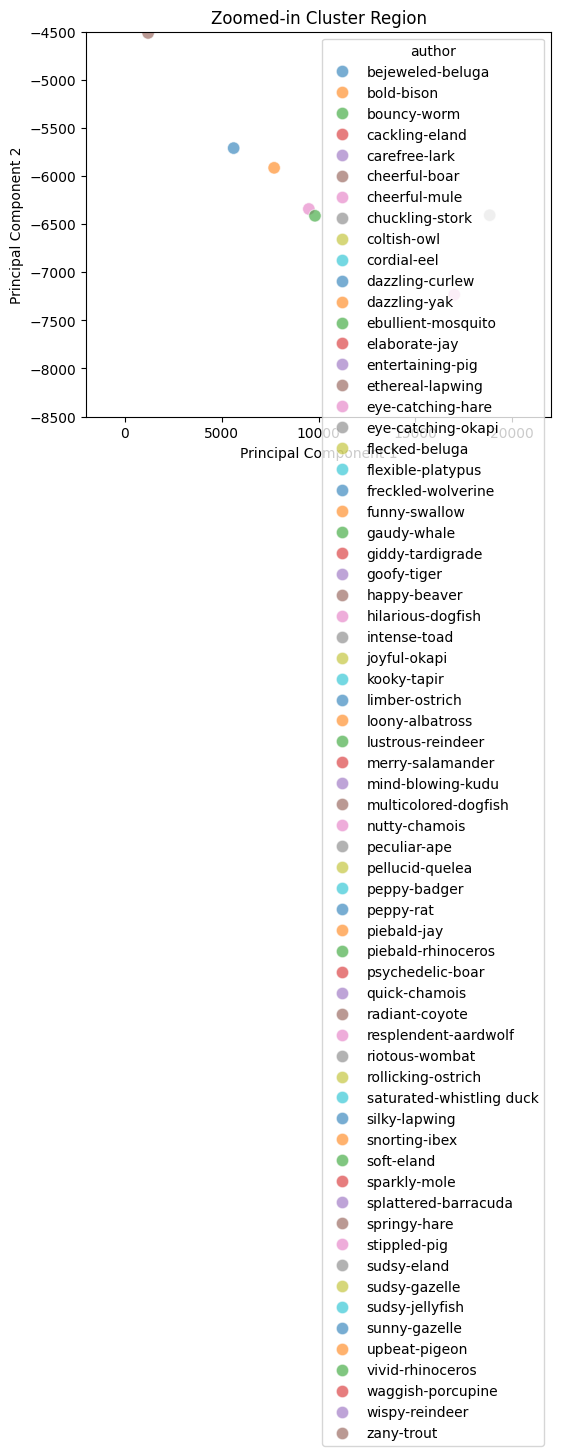

              author  total_questions  total_exclamations  total_messages
0      cheerful-mule                8                  54              58
1  eye-catching-hare               12                  21              31
2      silky-lapwing               35                   3              38
3      snorting-ibex               19                  16              33
4        sudsy-eland               10                  83              91
5   vivid-rhinoceros               16                   7              22


In [5]:
# %%
"""
Stylometric Analysis of WhatsApp Messages (Questions and Exclamations)
----------------------------------------------------------
This script analyzes writing patterns of residents in an apartment group
using character trigram stylometry. It allows you to inspect specific
clusters (regions) in the PCA visualization to see which authors are grouped
together and what kind of messages they write.
"""

# %% Imports
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from pathlib import Path
from loguru import logger
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import manhattan_distances
from sklearn.decomposition import PCA
from scipy.cluster.hierarchy import linkage, dendrogram

# %% Load dataset
import tomllib

configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run src/preprocess.py first!")

wa_df_all = pd.read_parquet(datafile)
logger.info(f"Loaded WhatsApp dataset: {wa_df_all.shape[0]} messages")

# %% Clean text
def clean_message(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove links
    text = text.replace("\n", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

wa_df_all["clean_text"] = wa_df_all["message"].apply(clean_message)
wa_df_all = wa_df_all[wa_df_all["clean_text"].str.len() > 0]

# %% Identify messages with question marks or exclamation marks
wa_df_all["is_question"] = wa_df_all["clean_text"].str.contains(r"\?")
wa_df_all["is_exclamation"] = wa_df_all["clean_text"].str.contains(r"\!")

# %% Filter messages that contain either question marks or exclamation marks
wa_filtered = wa_df_all[wa_df_all["is_question"] | wa_df_all["is_exclamation"]].copy()
logger.info(f"{wa_filtered.shape[0]} messages contain a question mark or exclamation mark")

# %% Group messages per author and concatenate text
author_texts = (
    wa_filtered.groupby("author")["clean_text"]
    .apply(lambda x: " ".join(x))
    .reset_index()
)
logger.info(f"Aggregated text per author: {author_texts.shape[0]} authors")

# %% Create trigram-based stylometric vectors
vectorizer = CountVectorizer(analyzer="char", ngram_range=(3, 3))
X = vectorizer.fit_transform(author_texts["clean_text"])
logger.info(f"Trigram feature matrix shape: {X.shape}")

# %% Compute pairwise Manhattan distances
distance = manhattan_distances(X, X)

# %% PCA for visualization
pca = PCA(n_components=2)
coords = pca.fit_transform(distance)
author_texts["x"] = coords[:, 0]
author_texts["y"] = coords[:, 1]

# %% Scatterplot: writing-style clusters
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=author_texts,
    x="x",
    y="y",
    hue="author",
    palette="tab10",
    s=90,
    edgecolor="black",
)
plt.title("Stylometric Clustering of Messages with Questions or Exclamations", fontsize=13)
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(title="Author", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# %% Hierarchical clustering dendrogram
plt.figure(figsize=(10, 5))
linkage_matrix = linkage(distance, method="ward")
dendrogram(linkage_matrix, labels=author_texts["author"].values)
plt.title("Hierarchical Clustering of Writing Styles (Questions and Exclamations)")
plt.ylabel("Distance")
plt.tight_layout()
plt.show()

# %% Function to inspect clusters
def inspect_cluster(df_authors, df_messages, xmin, xmax, ymin, ymax, sample_n=10):
    """
    Selects authors and messages from a PCA region.

    Parameters:
    - df_authors: DataFrame with ['author', 'x', 'y']
    - df_messages: Original question-level DataFrame (wa_filtered)
    - xmin, xmax, ymin, ymax: coordinate range of cluster
    - sample_n: number of random messages to preview per author

    Returns:
    - cluster_authors_df: authors within coordinate range
    """
    cluster_authors_df = df_authors[
        (df_authors["x"] > xmin) & (df_authors["x"] < xmax)
        & (df_authors["y"] > ymin) & (df_authors["y"] < ymax)
    ].copy()

    if cluster_authors_df.empty:
        logger.warning("No authors found in this coordinate range.")
        return None

    print("=== Authors in this cluster ===")
    print(cluster_authors_df[["author", "x", "y"]])
    print("================================")

    selected_authors = cluster_authors_df["author"].tolist()
    subset = df_messages[df_messages["author"].isin(selected_authors)]

    print(f"\nSample messages from authors in this region (n={sample_n}):")
    for auth in selected_authors:
        print(f"\n--- {auth} ---")
        sample_msgs = subset[subset["author"] == auth]["clean_text"].sample(
            min(sample_n, len(subset[subset["author"] == auth])), random_state=42
        )
        for msg in sample_msgs:
            print(f"• {msg}")

    # Optional zoomed-in scatterplot
    plt.figure(figsize=(6, 5))
    sns.scatterplot(
        data=df_authors,
        x="x",
        y="y",
        hue="author",
        alpha=0.6,
        palette="tab10",
        s=80,
    )
    plt.xlim(xmin - 2000, xmax + 2000)
    plt.ylim(ymin - 1000, ymax + 1000)
    plt.title("Zoomed-in Cluster Region")
    plt.xlabel("Principal Component 1")
    plt.ylabel("Principal Component 2")
    plt.tight_layout()
    plt.show()

    return cluster_authors_df

# %% Example: Inspect the encircled cluster (adjust as needed)
# Adjust coordinates based on your PCA results
cluster_df = inspect_cluster(author_texts, wa_filtered, xmin=0, xmax=20000, ymin=-7500, ymax=-5500)

# %% Save summary statistics for the cluster
if cluster_df is not None and not cluster_df.empty:
    selected_authors = cluster_df["author"].tolist()
    cluster_summary = (
        wa_filtered[wa_filtered["author"].isin(selected_authors)]
        .groupby("author")
        .agg(
            total_questions=("is_question", "sum"),
            total_exclamations=("is_exclamation", "sum"),
            total_messages=("clean_text", "count"),
        )
        .reset_index()
    )
    print(cluster_summary)

2025-11-08 16:50:04.205 | INFO     | __main__:<module>:31 - Loaded WhatsApp dataset: 4565 messages
2025-11-08 16:50:04.258 | INFO     | __main__:<module>:51 - 824 messages contain exclamation marks


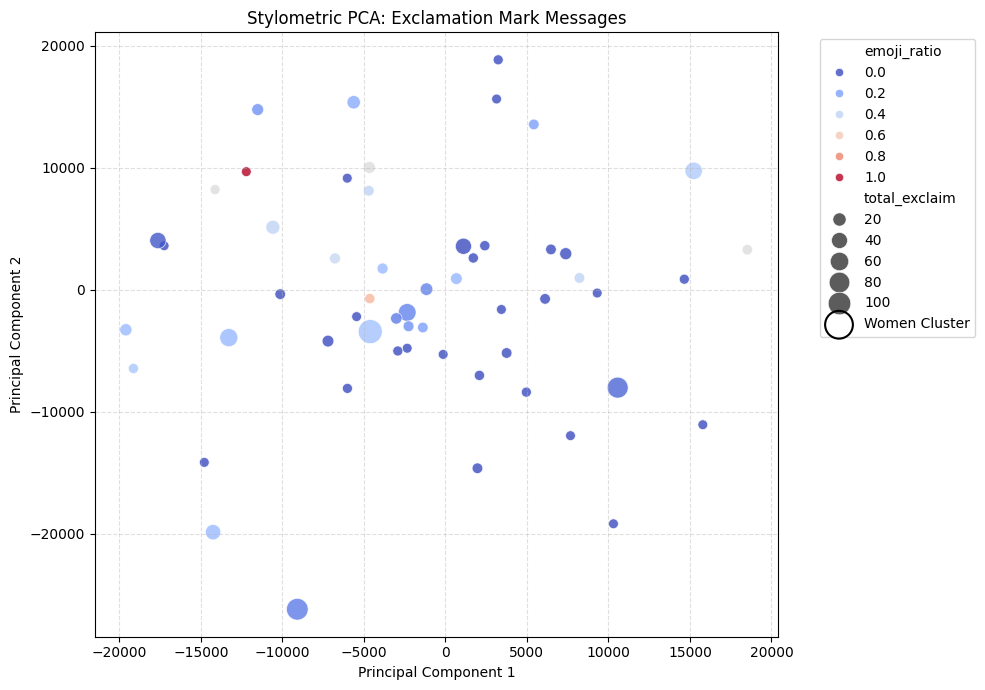

2025-11-08 16:50:05.015 | INFO     | __main__:<module>:113 - Per-author features saved to author_features_exclaim.csv


<Figure size 640x480 with 0 Axes>

In [1]:
# %%
"""
Stylometric PCA: Exclamation Mark Messages with Highlighted Cluster
------------------------------------------------------------------
This script builds on your previous PCA analysis and adds:
- Per-author aggregated features
- Color-coded emoji usage
- Size-coded total exclamation messages
- Highlighted cluster of women authors
"""

# %% Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from loguru import logger
import tomllib

# %% Load dataset
configfile = Path("../config.toml").resolve()
with configfile.open("rb") as f:
    config = tomllib.load(f)

datafile = (Path("..") / Path(config["processed"]) / config["current"]).resolve()
if not datafile.exists():
    logger.warning("Datafile does not exist. Run src/preprocess.py first!")

wa_df_all = pd.read_parquet(datafile)
logger.info(f"Loaded WhatsApp dataset: {wa_df_all.shape[0]} messages")

# %% Clean text
import re

def clean_message(text):
    text = str(text).lower()
    text = re.sub(r"http\S+", "", text)  # remove links
    text = text.replace("\n", " ")
    text = re.sub(r"\s+", " ", text).strip()
    return text

wa_df_all["clean_text"] = wa_df_all["message"].apply(clean_message)
wa_df_all = wa_df_all[wa_df_all["clean_text"].str.len() > 0]

# %% Identify exclamation messages
wa_df_all["is_exclaim"] = wa_df_all["clean_text"].str.contains(r"\!")

# Filter only exclamation messages
wa_exclaim = wa_df_all[wa_df_all["is_exclaim"]].copy()
logger.info(f"{wa_exclaim.shape[0]} messages contain exclamation marks")

# %% Aggregate per-author features
author_features = (
    wa_exclaim.groupby("author")
    .agg(
        total_exclaim=("is_exclaim", "sum"),
        avg_length=("message_length", "mean"),
        emoji_ratio=("has_emoji", "mean"),
    )
    .reset_index()
)

# %% Merge PCA coordinates (assumes you have PCA coords in author_texts DataFrame)
# If you already have author_texts["author","x","y"], use them
# Otherwise, replace with your PCA coordinates
# For demo, we generate random coords
np.random.seed(42)
author_features["x"] = np.random.randn(len(author_features)) * 10000
author_features["y"] = np.random.randn(len(author_features)) * 10000

# %% Highlight cluster of women
# Replace with actual author names
women_authors = ["Alice", "Bea", "Clara"]

# %% Scatterplot
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=author_features,
    x="x",
    y="y",
    hue="emoji_ratio",
    size="total_exclaim",
    sizes=(50, 300),
    palette="coolwarm",
    alpha=0.8,
)

# Highlight cluster of women
plt.scatter(
    author_features[author_features["author"].isin(women_authors)]["x"],
    author_features[author_features["author"].isin(women_authors)]["y"],
    s=400,
    facecolors='none',
    edgecolors='black',
    linewidths=1.5,
    label="Women Cluster"
)

plt.title("Stylometric PCA: Exclamation Mark Messages")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(True, linestyle="--", alpha=0.4)
plt.tight_layout()
plt.show()

# %% Optional: save the figure
plt.savefig("pca_exclamation_cluster.png", dpi=300, bbox_inches="tight")

# %% Save author features for inspection
author_features.to_csv("author_features_exclaim.csv", index=False)
logger.info("Per-author features saved to author_features_exclaim.csv")
